<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [17]</a>'.</span>

In [1]:
from graph import load_graphs, SparseGraph, graph_from_sparse,construct_graphs,feature_names,load_graph_combined
from model import SegmentClassifier
from estimator import Estimator
from torch.autograd import Variable
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.model_selection import train_test_split

In [2]:
cuda=True
if cuda:
    np_to_torch = lambda x, volatile=False: (
        torch.tensor(x.astype(np.float32), requires_grad=False).cuda())
else:
    np_to_torch = lambda x, volatile=False: (
        torch.tensor(x.astype(np.float32), requires_grad=False))

torch_to_np = lambda x: x.cpu().data.numpy()

In [3]:
import torch
from sklearn.model_selection import train_test_split
def merge_graphs(graphs):
    batch_size = len(graphs)
    
    # Special handling of batch size 1
    if batch_size == 1:
        g = graphs[0]
        # Prepend singleton batch dimension
        return g.X[None], g.Ri[None], g.Ro[None], g.y[None]
    
    # Get the maximum sizes in this batch
    n_features = graphs[0].X.shape[1]
    n_nodes = np.array([g.X.shape[0] for g in graphs])
    n_edges = np.array([g.y.shape[0] for g in graphs])
    max_nodes = n_nodes.max()
    max_edges = n_edges.max()

    # Allocate the tensors for this batch
    batch_X = np.zeros((batch_size, max_nodes, n_features), dtype=np.float32)
    batch_Ri = np.zeros((batch_size, max_nodes, max_edges), dtype=np.uint8)
    batch_Ro = np.zeros((batch_size, max_nodes, max_edges), dtype=np.uint8)
    batch_y = np.zeros((batch_size, max_edges), dtype=np.uint8)

    # Loop over samples and fill the tensors
    for i, g in enumerate(graphs):
        batch_X[i, :n_nodes[i]] = g.X
        batch_Ri[i, :n_nodes[i], :n_edges[i]] = g.Ri
        batch_Ro[i, :n_nodes[i], :n_edges[i]] = g.Ro
        batch_y[i, :n_edges[i]] = g.y
    
    return batch_X, batch_Ri, batch_Ro, batch_y

def batch_generator(graphs, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
            #print('batch', j, '-', j+batch_size)
            batch_graphs = [(g) for g in graphs[j:j+batch_size]]
            batch_X, batch_Ri, batch_Ro, batch_y = merge_graphs(batch_graphs)
            #print('  graphs merged')
            batch_inputs = [
                # torch.from_numpy(batch_X).cuda(),
                # torch.from_numpy(batch_Ri).cuda(),
                # torch.from_numpy(batch_Ro).cuda()
                np_to_torch(batch_X, volatile=volatile),
                np_to_torch(batch_Ri, volatile=volatile),
                np_to_torch(batch_Ro, volatile=volatile)
            ]
            batch_target = np_to_torch(batch_y, volatile=volatile)
            # batch_target=torch.from_numpy(batch_y).cuda()
            #print('  data prepared')
            yield batch_inputs, batch_target

In [4]:
import os
folder_path = "/lustrehome/federicacuna/TB_Sept_2023_ml/Data/npz_file_IN/"
lista=os.listdir(folder_path)

In [5]:
graph = [os.path.join(folder_path, file) for file in lista if ".ipynb_checkpoint" not in file  ]

In [6]:
# graphs=load_graphs(lista,folder_path)

In [7]:
def extract_number_from_filename(filename):
    return int(filename.split("_npz")[1].split(".npz")[0])

# Ordina i file basati sul numero compreso tra "_npz" e ".npz" nel loro nome
graph_data_sorted = sorted([os.path.join(folder_path, file) for file in graph], key=extract_number_from_filename)


In [8]:
%%time
data_for_train=[]
# for i in graph_data_sorted:
#     # print(i)
#     data_for_train.extend(load_graph_combined(i))
for i in range(100):#graph_data_sorted:
    print(i)
    i=graph_data_sorted[i]
    data_for_train.extend(load_graph_combined(i))

0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


CPU times: user 5h 3min 55s, sys: 16.6 s, total: 5h 4min 11s
Wall time: 5h 4min 45s


In [9]:
# graphs=load_graph_combined('test_npz.npz')
graphs=data_for_train

In [10]:
hidden_dim = 64
n_iters = 7
n_samples=len(graphs)
# Training config
batch_size = 1000#32
n_epochs = 100
valid_frac = 0.2
test_frac = 0.2
# We round by batch_size to avoid partial batches
n_test = int(n_samples * test_frac) // batch_size * batch_size
n_valid = int(n_samples * valid_frac) // batch_size * batch_size
n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
n_train_batches = n_train // batch_size
n_valid_batches = n_valid // batch_size
n_test_batches = n_test #// batch_size

n_train, n_valid, n_test, n_train + n_valid + n_test

(418000, 138000, 138000, 694000)

In [11]:
# Partition the dataset
train_graphs, test_graphs = train_test_split(graphs, test_size=n_test)
train_graphs, valid_graphs = train_test_split(train_graphs, test_size=n_valid)

print('Train set size:', len(train_graphs))
print('Valid set size:', len(valid_graphs))
print('Test set size: ', len(test_graphs))

Train set size: 418455
Valid set size: 138000
Test set size:  138000


In [12]:
# Prepare the batch generators
train_batcher = batch_generator(train_graphs, n_samples=n_train, batch_size=batch_size)
valid_batcher = batch_generator(valid_graphs, n_samples=n_valid, batch_size=batch_size, train=False)
test_batcher = batch_generator(test_graphs, n_samples=n_test, batch_size=1, train=False)

In [13]:
model = SegmentClassifier(input_dim=5, hidden_dim=hidden_dim, n_iters=n_iters)
loss_func = nn.functional.binary_cross_entropy
estim = Estimator(model, loss_func=loss_func, cuda=True)

2024-04-10 17:59:11.395583 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=138, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=207, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
)
2024-04-10 17:59:11.395740 Parameters: 26817


In [14]:
estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=100,
              valid_generator=valid_batcher, n_valid_batches=n_valid_batches, verbose=0)

2024-04-10 17:59:11.415160 Epoch 0


2024-04-10 17:59:41.968355   training loss 0.616 time 30.5531s


Epoch_stop: 0
2024-04-10 17:59:48.206519   validate loss 0.535
2024-04-10 17:59:48.206549 Epoch 1


2024-04-10 18:00:17.861276   training loss 0.441 time 29.6547s


Epoch_stop: 1
2024-04-10 18:00:23.674087   validate loss 0.346
2024-04-10 18:00:23.674111 Epoch 2


2024-04-10 18:00:52.629320   training loss 0.268 time 28.9552s


Epoch_stop: 2
2024-04-10 18:00:58.812559   validate loss 0.202
2024-04-10 18:00:58.812591 Epoch 3


2024-04-10 18:01:28.406697   training loss 0.156 time 29.5941s


Epoch_stop: 3
2024-04-10 18:01:34.505495   validate loss 0.12
2024-04-10 18:01:34.505524 Epoch 4


2024-04-10 18:02:04.409918   training loss 0.0973 time 29.9043s


Epoch_stop: 4
2024-04-10 18:02:10.302802   validate loss 0.0801
2024-04-10 18:02:10.302826 Epoch 5


2024-04-10 18:02:40.466010   training loss 0.0662 time 30.1631s


Epoch_stop: 5
2024-04-10 18:02:46.640542   validate loss 0.0567
2024-04-10 18:02:46.640573 Epoch 6


2024-04-10 18:03:15.753431   training loss 0.0506 time 29.1128s


Epoch_stop: 6
2024-04-10 18:03:21.732597   validate loss 0.045
2024-04-10 18:03:21.732622 Epoch 7


2024-04-10 18:03:51.770939   training loss 0.0406 time 30.0383s


Epoch_stop: 7
2024-04-10 18:03:58.128837   validate loss 0.0371
2024-04-10 18:03:58.128867 Epoch 8


2024-04-10 18:04:27.229960   training loss 0.035 time 29.101s


Epoch_stop: 8
2024-04-10 18:04:33.516112   validate loss 0.0328
2024-04-10 18:04:33.516140 Epoch 9


2024-04-10 18:05:02.707416   training loss 0.0318 time 29.1912s


Epoch_stop: 9
2024-04-10 18:05:08.566785   validate loss 0.0303
2024-04-10 18:05:08.566819 Epoch 10


2024-04-10 18:05:39.129722   training loss 0.0287 time 30.5629s


Epoch_stop: 10
2024-04-10 18:05:45.658008   validate loss 0.0278
2024-04-10 18:05:45.658030 Epoch 11


2024-04-10 18:06:16.502509   training loss 0.0269 time 30.8444s


Epoch_stop: 11
2024-04-10 18:06:23.022788   validate loss 0.0264
2024-04-10 18:06:23.022818 Epoch 12


2024-04-10 18:06:53.515537   training loss 0.0253 time 30.4927s


Epoch_stop: 12
2024-04-10 18:06:59.366966   validate loss 0.0249
2024-04-10 18:06:59.366991 Epoch 13


2024-04-10 18:07:29.880108   training loss 0.0254 time 30.5131s


2024-04-10 18:07:35.811166   validate loss 0.042
2024-04-10 18:07:35.811298 Epoch 14


2024-04-10 18:08:06.452121   training loss 0.0288 time 30.6408s


Epoch_stop: 14
2024-04-10 18:08:12.691761   validate loss 0.0246
2024-04-10 18:08:12.691793 Epoch 15


2024-04-10 18:08:43.101069   training loss 0.0245 time 30.4092s


Epoch_stop: 15
2024-04-10 18:08:49.313225   validate loss 0.0243
2024-04-10 18:08:49.313247 Epoch 16


2024-04-10 18:09:19.057421   training loss 0.0233 time 29.7441s


Epoch_stop: 16
2024-04-10 18:09:24.956966   validate loss 0.0232
2024-04-10 18:09:24.956996 Epoch 17


2024-04-10 18:09:55.794253   training loss 0.0227 time 30.8372s


Epoch_stop: 17
2024-04-10 18:10:02.332717   validate loss 0.0224
2024-04-10 18:10:02.332748 Epoch 18


2024-04-10 18:10:32.962735   training loss 0.0219 time 30.6299s


Epoch_stop: 18
2024-04-10 18:10:39.369712   validate loss 0.0221
2024-04-10 18:10:39.369745 Epoch 19


2024-04-10 18:11:10.428061   training loss 0.0224 time 31.0583s


Epoch_stop: 19
2024-04-10 18:11:16.143920   validate loss 0.0216
2024-04-10 18:11:16.143942 Epoch 20


2024-04-10 18:11:45.481926   training loss 0.0212 time 29.3379s


Epoch_stop: 20
2024-04-10 18:11:51.695809   validate loss 0.0213
2024-04-10 18:11:51.695833 Epoch 21


2024-04-10 18:12:21.320328   training loss 0.0227 time 29.6244s


2024-04-10 18:12:27.283468   validate loss 0.0229
2024-04-10 18:12:27.283589 Epoch 22


2024-04-10 18:12:57.664348   training loss 0.022 time 30.3807s


2024-04-10 18:13:03.481646   validate loss 0.0217
2024-04-10 18:13:03.481779 Epoch 23


2024-04-10 18:13:33.625552   training loss 0.0226 time 30.1437s


2024-04-10 18:13:39.811543   validate loss 0.0221
2024-04-10 18:13:39.811866 Epoch 24


2024-04-10 18:14:10.401283   training loss 0.0224 time 30.5894s


2024-04-10 18:14:16.523182   validate loss 0.0221
2024-04-10 18:14:16.523310 Epoch 25


2024-04-10 18:14:46.957086   training loss 0.0222 time 30.4337s


2024-04-10 18:14:52.735119   validate loss 0.0248
2024-04-10 18:14:52.735330 Epoch 26


2024-04-10 18:15:23.642422   training loss 0.0225 time 30.907s


2024-04-10 18:15:29.884259   validate loss 0.0216
2024-04-10 18:15:29.884571 Epoch 27


2024-04-10 18:15:59.245905   training loss 0.0202 time 29.3613s


Epoch_stop: 27
2024-04-10 18:16:05.221469   validate loss 0.0202
2024-04-10 18:16:05.221501 Epoch 28


2024-04-10 18:16:35.471254   training loss 0.0242 time 30.2497s


2024-04-10 18:16:41.768273   validate loss 0.0243
2024-04-10 18:16:41.768418 Epoch 29


2024-04-10 18:17:12.235539   training loss 0.023 time 30.4671s


2024-04-10 18:17:18.110662   validate loss 0.0221
2024-04-10 18:17:18.110783 Epoch 30


2024-04-10 18:17:47.874954   training loss 0.0208 time 29.7641s


2024-04-10 18:17:54.287698   validate loss 0.0208
2024-04-10 18:17:54.287937 Epoch 31


2024-04-10 18:18:24.618986   training loss 0.0225 time 30.331s


2024-04-10 18:18:30.590943   validate loss 0.0224
2024-04-10 18:18:30.591075 Epoch 32


2024-04-10 18:19:01.437854   training loss 0.0215 time 30.8467s


2024-04-10 18:19:07.330967   validate loss 0.0218
2024-04-10 18:19:07.331117 Epoch 33


2024-04-10 18:19:37.671421   training loss 0.0221 time 30.3403s


2024-04-10 18:19:43.766721   validate loss 0.0255
2024-04-10 18:19:43.766998 Epoch 34


2024-04-10 18:20:13.649031   training loss 0.0224 time 29.882s


2024-04-10 18:20:19.764337   validate loss 0.0221
2024-04-10 18:20:19.764455 Epoch 35


2024-04-10 18:20:50.502870   training loss 0.0211 time 30.7384s


2024-04-10 18:20:56.480886   validate loss 0.0213
2024-04-10 18:20:56.481022 Epoch 36


2024-04-10 18:21:26.684357   training loss 0.0204 time 30.2033s


Epoch_stop: 36
2024-04-10 18:21:32.846366   validate loss 0.0201
2024-04-10 18:21:32.846397 Epoch 37


2024-04-10 18:22:03.156903   training loss 0.0222 time 30.3105s


2024-04-10 18:22:09.264596   validate loss 0.0221
2024-04-10 18:22:09.264738 Epoch 38


2024-04-10 18:22:38.504470   training loss 0.0217 time 29.2397s


2024-04-10 18:22:44.477174   validate loss 0.0218
2024-04-10 18:22:44.477389 Epoch 39


2024-04-10 18:23:14.384827   training loss 0.0245 time 29.9074s


2024-04-10 18:23:20.521670   validate loss 0.0279
2024-04-10 18:23:20.521790 Epoch 40


2024-04-10 18:23:50.163553   training loss 0.0222 time 29.6417s


2024-04-10 18:23:56.192389   validate loss 0.0208
2024-04-10 18:23:56.192627 Epoch 41


2024-04-10 18:24:25.504442   training loss 0.0219 time 29.3118s


2024-04-10 18:24:31.638759   validate loss 0.022
2024-04-10 18:24:31.638894 Epoch 42


2024-04-10 18:25:02.036156   training loss 0.0223 time 30.3972s


2024-04-10 18:25:08.305218   validate loss 0.0215
2024-04-10 18:25:08.305502 Epoch 43


2024-04-10 18:25:38.436228   training loss 0.0221 time 30.1307s


2024-04-10 18:25:44.553516   validate loss 0.022
2024-04-10 18:25:44.553832 Epoch 44


2024-04-10 18:26:14.810247   training loss 0.0221 time 30.2564s


2024-04-10 18:26:20.816801   validate loss 0.0217
2024-04-10 18:26:20.817068 Epoch 45


2024-04-10 18:26:51.415022   training loss 0.0213 time 30.5979s


2024-04-10 18:26:57.790628   validate loss 0.0215
2024-04-10 18:26:57.790937 Epoch 46


2024-04-10 18:27:28.095350   training loss 0.021 time 30.3044s


2024-04-10 18:27:34.248113   validate loss 0.0215
2024-04-10 18:27:34.248420 Epoch 47


2024-04-10 18:28:04.638943   training loss 0.0211 time 30.3905s


2024-04-10 18:28:10.535269   validate loss 0.0212
2024-04-10 18:28:10.535553 Epoch 48


2024-04-10 18:28:41.008683   training loss 0.0213 time 30.4731s


2024-04-10 18:28:47.171600   validate loss 0.0227
2024-04-10 18:28:47.171726 Epoch 49


2024-04-10 18:29:17.900720   training loss 0.0283 time 30.7289s


2024-04-10 18:29:24.107486   validate loss 0.0294
2024-04-10 18:29:24.107620 Epoch 50


2024-04-10 18:29:54.711664   training loss 0.0269 time 30.604s


2024-04-10 18:30:01.035454   validate loss 0.0266
2024-04-10 18:30:01.035749 Epoch 51


2024-04-10 18:30:30.911833   training loss 0.0255 time 29.876s


2024-04-10 18:30:37.288547   validate loss 0.0255
2024-04-10 18:30:37.288777 Epoch 52


2024-04-10 18:31:07.716082   training loss 0.0247 time 30.4272s


2024-04-10 18:31:13.774299   validate loss 0.0249
2024-04-10 18:31:13.774429 Epoch 53


2024-04-10 18:31:43.155663   training loss 0.0243 time 29.3812s


2024-04-10 18:31:49.662602   validate loss 0.0244
2024-04-10 18:31:49.662889 Epoch 54


2024-04-10 18:32:20.581758   training loss 0.0231 time 30.9188s


2024-04-10 18:32:27.039208   validate loss 0.0231
2024-04-10 18:32:27.039510 Epoch 55


2024-04-10 18:32:56.373594   training loss 0.0225 time 29.334s


2024-04-10 18:33:02.242019   validate loss 0.0228
2024-04-10 18:33:02.242152 Epoch 56


2024-04-10 18:33:33.073293   training loss 0.0222 time 30.8311s


2024-04-10 18:33:39.306312   validate loss 0.0225
2024-04-10 18:33:39.306440 Epoch 57


2024-04-10 18:34:08.756922   training loss 0.0224 time 29.4504s


2024-04-10 18:34:14.598873   validate loss 0.0232
2024-04-10 18:34:14.599175 Epoch 58


2024-04-10 18:34:45.549089   training loss 0.0224 time 30.9499s


2024-04-10 18:34:51.887496   validate loss 0.0222
2024-04-10 18:34:51.887769 Epoch 59


2024-04-10 18:35:21.967225   training loss 0.0218 time 30.0794s


2024-04-10 18:35:27.825839   validate loss 0.022
2024-04-10 18:35:27.826102 Epoch 60


2024-04-10 18:35:58.594417   training loss 0.0217 time 30.7683s


2024-04-10 18:36:04.893021   validate loss 0.0219
2024-04-10 18:36:04.893257 Epoch 61


2024-04-10 18:36:35.226029   training loss 0.0216 time 30.3327s


2024-04-10 18:36:41.381954   validate loss 0.0218
2024-04-10 18:36:41.382068 Epoch 62


2024-04-10 18:37:11.471708   training loss 0.022 time 30.0896s


2024-04-10 18:37:17.716227   validate loss 0.0218
2024-04-10 18:37:17.716895 Epoch 63


2024-04-10 18:37:48.859236   training loss 0.0217 time 31.1423s


2024-04-10 18:37:54.472264   validate loss 0.0234
2024-04-10 18:37:54.472413 Epoch 64


2024-04-10 18:38:25.340285   training loss 0.022 time 30.8676s


2024-04-10 18:38:31.853492   validate loss 0.0222
2024-04-10 18:38:31.853773 Epoch 65


2024-04-10 18:39:03.007633   training loss 0.0213 time 31.1538s


2024-04-10 18:39:09.023848   validate loss 0.0206
2024-04-10 18:39:09.024103 Epoch 66


2024-04-10 18:39:39.393683   training loss 0.021 time 30.3695s


2024-04-10 18:39:45.383205   validate loss 0.0211
2024-04-10 18:39:45.383445 Epoch 67


2024-04-10 18:40:15.968786   training loss 0.0207 time 30.5853s


2024-04-10 18:40:22.414269   validate loss 0.0208
2024-04-10 18:40:22.414544 Epoch 68


2024-04-10 18:40:52.966209   training loss 0.0245 time 30.5516s


2024-04-10 18:40:59.021970   validate loss 0.022
2024-04-10 18:40:59.022250 Epoch 69


2024-04-10 18:41:28.816452   training loss 0.0204 time 29.7942s


2024-04-10 18:41:35.146098   validate loss 0.0205
2024-04-10 18:41:35.146317 Epoch 70


2024-04-10 18:42:05.672927   training loss 0.0211 time 30.5266s


2024-04-10 18:42:11.995655   validate loss 0.0275
2024-04-10 18:42:11.995932 Epoch 71


2024-04-10 18:42:42.541551   training loss 0.0247 time 30.5456s


2024-04-10 18:42:48.777450   validate loss 0.0244
2024-04-10 18:42:48.777709 Epoch 72


2024-04-10 18:43:18.451626   training loss 0.0239 time 29.6739s


2024-04-10 18:43:24.623485   validate loss 0.0238
2024-04-10 18:43:24.623614 Epoch 73


2024-04-10 18:43:55.328421   training loss 0.0236 time 30.7048s


2024-04-10 18:44:01.840430   validate loss 0.023
2024-04-10 18:44:01.840705 Epoch 74


2024-04-10 18:44:32.163343   training loss 0.0224 time 30.3226s


2024-04-10 18:44:38.559650   validate loss 0.0227
2024-04-10 18:44:38.559921 Epoch 75


2024-04-10 18:45:08.440092   training loss 0.0222 time 29.8801s


2024-04-10 18:45:14.701851   validate loss 0.0224
2024-04-10 18:45:14.701966 Epoch 76


2024-04-10 18:45:43.583711   training loss 0.022 time 28.8817s


2024-04-10 18:45:49.390273   validate loss 0.0226
2024-04-10 18:45:49.390454 Epoch 77


2024-04-10 18:46:19.257186   training loss 0.0223 time 29.8667s


2024-04-10 18:46:25.352993   validate loss 0.0241
2024-04-10 18:46:25.353309 Epoch 78


2024-04-10 18:46:56.103907   training loss 0.0229 time 30.7506s


2024-04-10 18:47:02.701120   validate loss 0.0232
2024-04-10 18:47:02.701372 Epoch 79


2024-04-10 18:47:33.250447   training loss 0.0219 time 30.549s


2024-04-10 18:47:39.566260   validate loss 0.022
2024-04-10 18:47:39.566536 Epoch 80


2024-04-10 18:48:09.732735   training loss 0.0218 time 30.1662s


2024-04-10 18:48:15.856731   validate loss 0.0247
2024-04-10 18:48:15.856854 Epoch 81


2024-04-10 18:48:46.126566   training loss 0.023 time 30.2697s


2024-04-10 18:48:52.167994   validate loss 0.023
2024-04-10 18:48:52.168251 Epoch 82


2024-04-10 18:49:22.319393   training loss 0.0226 time 30.1511s


2024-04-10 18:49:28.222166   validate loss 0.0226
2024-04-10 18:49:28.222456 Epoch 83


2024-04-10 18:49:59.062526   training loss 0.0224 time 30.84s


2024-04-10 18:50:05.446266   validate loss 0.024
2024-04-10 18:50:05.446468 Epoch 84


2024-04-10 18:50:35.137908   training loss 0.0225 time 29.6914s


2024-04-10 18:50:41.335808   validate loss 0.022
2024-04-10 18:50:41.335946 Epoch 85


2024-04-10 18:51:11.982362   training loss 0.0215 time 30.6464s


2024-04-10 18:51:18.425403   validate loss 0.0215
2024-04-10 18:51:18.425672 Epoch 86


2024-04-10 18:51:48.645298   training loss 0.0218 time 30.2196s


2024-04-10 18:51:54.637129   validate loss 0.0218
2024-04-10 18:51:54.637372 Epoch 87


2024-04-10 18:52:23.767103   training loss 0.0211 time 29.1297s


2024-04-10 18:52:29.794248   validate loss 0.0214
2024-04-10 18:52:29.794393 Epoch 88


2024-04-10 18:53:00.870392   training loss 0.0209 time 31.076s


2024-04-10 18:53:07.029856   validate loss 0.0209
2024-04-10 18:53:07.030128 Epoch 89


2024-04-10 18:53:36.808198   training loss 0.0206 time 29.778s


2024-04-10 18:53:42.952861   validate loss 0.021
2024-04-10 18:53:42.953121 Epoch 90


2024-04-10 18:54:13.426253   training loss 0.0208 time 30.4731s


2024-04-10 18:54:19.548447   validate loss 0.0211
2024-04-10 18:54:19.548691 Epoch 91


2024-04-10 18:54:50.310122   training loss 0.0214 time 30.7614s


2024-04-10 18:54:56.256087   validate loss 0.0224
2024-04-10 18:54:56.256212 Epoch 92


2024-04-10 18:55:25.870711   training loss 0.0209 time 29.6144s


2024-04-10 18:55:32.231906   validate loss 0.0209
2024-04-10 18:55:32.232154 Epoch 93


2024-04-10 18:56:02.677339   training loss 0.0213 time 30.4451s


2024-04-10 18:56:08.449618   validate loss 0.0217
2024-04-10 18:56:08.449766 Epoch 94


2024-04-10 18:56:38.800469   training loss 0.0208 time 30.3507s


2024-04-10 18:56:45.158127   validate loss 0.0218
2024-04-10 18:56:45.158357 Epoch 95


2024-04-10 18:57:14.932752   training loss 0.0212 time 29.7743s


2024-04-10 18:57:21.203987   validate loss 0.0221
2024-04-10 18:57:21.204291 Epoch 96


2024-04-10 18:57:51.282610   training loss 0.0256 time 30.0783s


2024-04-10 18:57:57.598102   validate loss 0.0243
2024-04-10 18:57:57.598363 Epoch 97


2024-04-10 18:58:28.347220   training loss 0.0235 time 30.7488s


2024-04-10 18:58:34.724928   validate loss 0.024
2024-04-10 18:58:34.725176 Epoch 98


2024-04-10 18:59:05.012326   training loss 0.0228 time 30.2871s


2024-04-10 18:59:11.074951   validate loss 0.0227
2024-04-10 18:59:11.075208 Epoch 99


2024-04-10 18:59:41.017378   training loss 0.0222 time 29.9421s


2024-04-10 18:59:47.483008   validate loss 0.0228


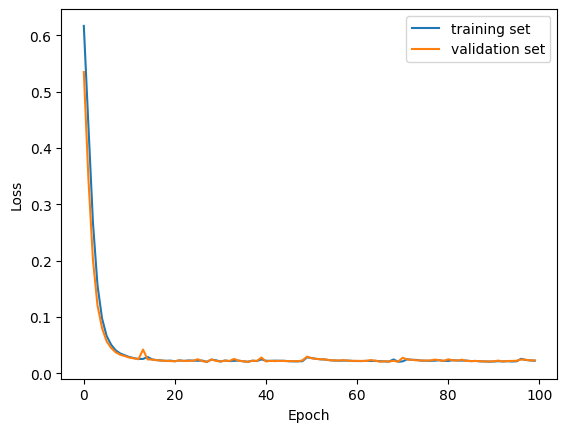

In [15]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0);

In [16]:
len(test_graphs)

138000

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [17]:
test_batcher = batch_generator(test_graphs, n_samples=n_test, batch_size=1, train=False)
test_outputs = estim.predict(test_batcher,'best_model_IN.pkl', n_test_batches, concat=False)
test_preds = [torch_to_np(o) for o in test_outputs]

# Flatten the predictions and labels
flat_y = np.concatenate([g.y.flatten() for g in test_graphs])
flat_pred = np.concatenate([p.flatten() for p in test_preds])
thresh = 0.8
print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(flat_y, flat_pred>thresh))
print('Precision: %.4f' % sklearn.metrics.precision_score(flat_y, flat_pred>thresh))
print('Recall:    %.4f' % sklearn.metrics.recall_score(flat_y, flat_pred>thresh))

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 39.38 GiB of which 2.25 MiB is free. Process 30267 has 664.00 MiB memory in use. Process 49283 has 19.27 GiB memory in use. Including non-PyTorch memory, this process has 19.44 GiB memory in use. Of the allocated memory 18.88 GiB is allocated by PyTorch, and 64.44 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)
plt.figure(figsize=(9,4))

# Plot the model outputs
plt.subplot(121)
binning=dict(bins=50, range=(0,1), histtype='bar')
plt.hist(flat_pred[flat_y<0.5], label='fake', **binning)
plt.hist(flat_pred[flat_y>0.5], label='true', **binning)
plt.xlabel('Model output')
plt.legend(loc=0)

# Plot the ROC curve
plt.subplot(122)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.tight_layout()

In [ ]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=False):
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, ax0 = plt.subplots(figsize=(9,4))
    cmap = plt.get_cmap(cmap)

    ax0.scatter(X[:,2], X[:,1], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='b', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,1], feats_i[j,1]], '-', **seg_args)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(y)
    cbar = plt.colorbar(sm, ax=ax0)
    cbar.set_label('Colorbar Label')  # Set the label for the colorbar
    
    # Adjust axes
    ax0.set_xlabel('zx_hit [mm]')
    ax0.set_ylabel('x_hit ')
    ax0.set_xlim(-100,2000)
    ax0.set_ylim(-20,20)
    plt.tight_layout()
    plt.show()

In [ ]:
for i in range(4):
    g = (test_graphs[i])
    pred = test_preds[i].squeeze(0)
    print(pred)
    print('accuracy %.3f, precision %.3f, recall %.3f' % (
        sklearn.metrics.accuracy_score(g.y, pred>thresh),
        sklearn.metrics.precision_score(g.y, pred>thresh),
        sklearn.metrics.recall_score(g.y, pred>thresh)))
    draw_sample(g.X, g.Ri, g.Ro, pred, alpha_labels=False);